## Standard python things

Doing standard things like importing the relevant packages, or defining where to import the dataset from.

In [815]:
#Importing standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from datetime import datetime
import time

In [816]:
#Defining the paths to the data-set. This makes the .read_cvs easier to read later on
nomad_cities_url = "https://raw.githubusercontent.com/SDS-AAU/SDS-master/master/M1/data/nomad_cities.csv"
trips_url = "https://raw.githubusercontent.com/SDS-AAU/SDS-master/master/M1/data/trips.csv"
people_url = 'https://raw.githubusercontent.com/SDS-AAU/SDS-master/master/M1/data/people.csv'
countries_url = 'https://raw.githubusercontent.com/SDS-AAU/SDS-master/master/M1/data/countrylist.csv'

# Task 1 - preprocessing
a. Trips: transform dates into timestamps (note: in Python, you will have to ‘coerce’ errors for
faulty dates)

b. Calculate trip duration in days (you can use loops, list comprehensions or map-lambda-functions
(python) to create a column that holds the numerical value of the day. You can also use the
“datetime” package.)

c. Filter extreme (fake?) observations for durations as well as dates - start and end (trips that last
234565 days / are in the 17th or 23rd century) The minimum duration of a trip is 1 day! Hint: use
percentiles/quantiles to set boundaries for extreme values - between 1 and 97, calculate and store
the boundaries before subsetting.
percentiles

d. Join the countrylist data to the trips data-frame using the countrycode as a key e. [Only for
python users ] Set DateTime index as the start date of a trip


In [817]:
#Importing the trips dataset. 
trips = pd.read_csv(trips_url)

In [818]:
#To understand the data we get info on the data and head on the data.
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46510 entries, 0 to 46509
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    46510 non-null  int64 
 1   username      46510 non-null  object
 2   country       46473 non-null  object
 3   country_code  45909 non-null  object
 4   country_slug  46473 non-null  object
 5   date_end      46335 non-null  object
 6   date_start    46510 non-null  object
 7   latitude      46510 non-null  int64 
 8   longitude     46510 non-null  int64 
 9   place         46510 non-null  object
 10  place_slug    46473 non-null  object
dtypes: int64(3), object(8)
memory usage: 3.9+ MB


In [819]:
#Including the 5 first datapoints.
trips.head()

,Unnamed: 0,username,country,country_code,country_slug,date_end,date_start,latitude,longitude,place,place_slug
0,0,@lewellenmichael,Mexico,MX,mexico,2018-06-15,2018-06-04,21,-101,Guanajuato,mexico
1,1,@lewellenmichael,Mexico,MX,mexico,2018-06-03,2018-05-31,19,-99,Mexico City,mexico-city-mexico
2,2,@lewellenmichael,Mexico,MX,mexico,2017-11-05,2017-11-01,21,-86,Cancun,cancun-mexico
3,3,@lewellenmichael,Jordan,JO,jordan,2017-08-07,2017-07-24,31,35,Amman,amman-jordan
4,4,@waylandchin,China,CN,china,2017-03-18,2017-02-17,40,122,Yingkou,china


We can see that the left-most column seems to be an index that was already in the dataset. As we automatically get an index in Colab, we can drop that column.

Because we can see from the info, that all variables have the ~same amount of non-null objects, we can just drop rows that contain NaN-values, even though we might miss out on some data. Had we had a variable that contained 0 non-null objects, we would remove all data, if we droppes NaN-values.

In [820]:
#We use axis=1 for columns, and InPlace to not have to define a new object.
trips.drop('Unnamed: 0', axis=1, inplace=True)

#Now we use axis=0 because we want to delete rows (observations) with NaN values.
trips.dropna(axis=0, how='any', inplace=True)

In [821]:
#We now see that all variable have the same amount of non-nulls
trips.info()
trips.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45736 entries, 0 to 46509
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   username      45736 non-null  object
 1   country       45736 non-null  object
 2   country_code  45736 non-null  object
 3   country_slug  45736 non-null  object
 4   date_end      45736 non-null  object
 5   date_start    45736 non-null  object
 6   latitude      45736 non-null  int64 
 7   longitude     45736 non-null  int64 
 8   place         45736 non-null  object
 9   place_slug    45736 non-null  object
dtypes: int64(2), object(8)
memory usage: 3.8+ MB


,username,country,country_code,country_slug,date_end,date_start,latitude,longitude,place,place_slug
0,@lewellenmichael,Mexico,MX,mexico,2018-06-15,2018-06-04,21,-101,Guanajuato,mexico
1,@lewellenmichael,Mexico,MX,mexico,2018-06-03,2018-05-31,19,-99,Mexico City,mexico-city-mexico
2,@lewellenmichael,Mexico,MX,mexico,2017-11-05,2017-11-01,21,-86,Cancun,cancun-mexico
3,@lewellenmichael,Jordan,JO,jordan,2017-08-07,2017-07-24,31,35,Amman,amman-jordan
4,@waylandchin,China,CN,china,2017-03-18,2017-02-17,40,122,Yingkou,china


#a. Converting to a timestamp

Right now the date columns are objects, and we want them to be timestamps.We first start by converting to a timestamp. To do so, we create a new dataframe, which we then use the to_datetime to convert into a datetime, which is then used to calculate the traveltime. 

In [822]:
date_end = trips.date_end
date_start = trips.date_start

#Replacing the object variable with a datetime64 variable
trips['date_end'] = pd.to_datetime(date_end,errors="coerce")
trips['date_start'] = pd.to_datetime(date_start,errors="coerce")

#b. Calculating trip duration in days.

Since we converted the variable to datetime64, we can simply subtract the start date from the end date, and then we get the duration 

In [823]:
#Adding a new variable that calculates the duration of a trip
trips['trip_duration'] = trips['date_end'] - trips['date_start']

#c. Filter extreme cases away

In [824]:
#Next we filter out those with a trip start in the future

#First we define now (so that it changes itself in the future instead of setting a stock variable)
now = datetime.now()

#Now we remove those trips that have a start date and an end date in the future. 
trips = trips[(trips.date_start < now) & (trips.date_end < now)]

To filter the extreme observations we can look at different percentiles and their values. People very rarely have nomad trips that last above one year (365 days) so we can filter away those above. One could argue that a trip could last more than a year, but for the easyness, let's not.

In [825]:
#Upperlimit at 365 whole days
trips_upperlimit = np.percentile(trips['trip_duration'],98.2)
#Lowerlimit at 1 whole day (as defined in the question)
trips_lowerlimit = np.percentile(trips['trip_duration'],5)

#We could convert to seconds/hours/days but there is no reason to do so, besides to easily control what the percentiles is when changing around
#To do so, we could use the below code to figure out that anything below the 5th percentile is less than a day
#Since the task states that 1 day is the minimum for a trip, anything below the 5th percentile will be filtered away as those aren't whole days
#Same thing goes for anything above the 98.2nd percentile

#trips_1percentile = np.percentile(trips['trip_duration'],5)
#trips_1percentile_seconds = trips_1percentile / 1000000000
#trips_1percentile_minutes = trips_1percentile_seconds / 60
#trips_1percentile_hours = trips_1percentile_minutes / 60
#trips_1percentile_whole_days = trips_1percentile_hours / 24
#print(trips_1percentile_whole_days)

In [826]:
#Now we have the limits to filter out any trips below 1 day and above 365 days. Time to subset the data
trips = trips[(trips.trip_duration > trips_lowerlimit) & (trips.trip_duration < trips_upperlimit)]

In [827]:
#Lets see how many observations we have left - still 42552 observations.
trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43333 entries, 0 to 46509
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   username       43333 non-null  object         
 1   country        43333 non-null  object         
 2   country_code   43333 non-null  object         
 3   country_slug   43333 non-null  object         
 4   date_end       43333 non-null  datetime64[ns] 
 5   date_start     43333 non-null  datetime64[ns] 
 6   latitude       43333 non-null  int64          
 7   longitude      43333 non-null  int64          
 8   place          43333 non-null  object         
 9   place_slug     43333 non-null  object         
 10  trip_duration  43333 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), int64(2), object(6), timedelta64[ns](1)
memory usage: 4.0+ MB


# d. Joining countrylist


In [828]:
#We start by reading the countrylist
countries = pd.read_csv(countries_url)

In [829]:
#Lets check the contries data
countries.head()

,alpha_2,region,sub_region
0,AF,Asia,Southern Asia
1,AX,Europe,Northern Europe
2,AL,Europe,Southern Europe
3,DZ,Africa,Northern Africa
4,AS,Oceania,Polynesia


In [830]:
#We see already that we are going to have a problem when merging, because the variable is not called country_code in this data-set, so lets change that.
countries.columns = ['country_code','Region','sub_region']
countries.head()

,country_code,Region,sub_region
0,AF,Asia,Southern Asia
1,AX,Europe,Northern Europe
2,AL,Europe,Southern Europe
3,DZ,Africa,Northern Africa
4,AS,Oceania,Polynesia


In [831]:
#Lets get merging. We want to keep the data in the trips DataFrame, so we want to merge left, and we state we want to merge on country_code
trips = pd.merge(trips,countries,how='left',on='country_code')
trips.head()

,username,country,country_code,country_slug,date_end,date_start,latitude,longitude,place,place_slug,trip_duration,Region,sub_region
0,@lewellenmichael,Mexico,MX,mexico,2018-06-15,2018-06-04,21,-101,Guanajuato,mexico,11 days,Americas,Latin America and the Caribbean
1,@lewellenmichael,Mexico,MX,mexico,2018-06-03,2018-05-31,19,-99,Mexico City,mexico-city-mexico,3 days,Americas,Latin America and the Caribbean
2,@lewellenmichael,Mexico,MX,mexico,2017-11-05,2017-11-01,21,-86,Cancun,cancun-mexico,4 days,Americas,Latin America and the Caribbean
3,@lewellenmichael,Jordan,JO,jordan,2017-08-07,2017-07-24,31,35,Amman,amman-jordan,14 days,Asia,Western Asia
4,@waylandchin,China,CN,china,2017-03-18,2017-02-17,40,122,Yingkou,china,29 days,Asia,Eastern Asia


Now we need to set the DateTime as index. We will be using the starting date of the trips as the index

In [832]:
#We use the code df.set_index() to do so
trips.set_index('date_start', inplace=True)

In [833]:
#Lets see the result - as we can see, the index is now the starting date.
trips.head()

,username,country,country_code,country_slug,date_end,latitude,longitude,place,place_slug,trip_duration,Region,sub_region
date_start,,,,,,,,,,,,
2018-06-04,@lewellenmichael,Mexico,MX,mexico,2018-06-15,21,-101,Guanajuato,mexico,11 days,Americas,Latin America and the Caribbean
2018-05-31,@lewellenmichael,Mexico,MX,mexico,2018-06-03,19,-99,Mexico City,mexico-city-mexico,3 days,Americas,Latin America and the Caribbean
2017-11-01,@lewellenmichael,Mexico,MX,mexico,2017-11-05,21,-86,Cancun,cancun-mexico,4 days,Americas,Latin America and the Caribbean
2017-07-24,@lewellenmichael,Jordan,JO,jordan,2017-08-07,31,35,Amman,amman-jordan,14 days,Asia,Western Asia
2017-02-17,@waylandchin,China,CN,china,2017-03-18,40,122,Yingkou,china,29 days,Asia,Eastern Asia


# 2. People

Lets start of with all the generals. The packages are already loaded, but lets read the people dataset and explore it with head and info.


In [834]:
people = pd.read_csv(people_url)

In [835]:
people.head()

,Unnamed: 0,username,followers,following,work_raw,education_raw
0,0,@lewellenmichael,1,2,"Software Dev, Startup Founder, Finance, Crypto...","High School, Bachelor's Degree"
1,1,@waylandchin,0,2,NaN,NaN
2,2,@karan,2,1,NaN,NaN
3,3,@skaboss217,0,1,NaN,NaN
4,4,@apwn,17,426,Web Dev,NaN


In [836]:
people.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4016 entries, 0 to 4015
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     4016 non-null   int64 
 1   username       4016 non-null   object
 2   followers      4016 non-null   int64 
 3   following      4016 non-null   int64 
 4   work_raw       1582 non-null   object
 5   education_raw  451 non-null    object
dtypes: int64(3), object(3)
memory usage: 188.4+ KB


In [837]:
#Once again we see the double index. Lets remove that once more.
people.drop('Unnamed: 0', axis=1, inplace=True)

#a. High-school diplomas

In [838]:
#Now we create a boolean value with those where the education_raw variable contains "High School" We use regex=False to let python know it is a literal string, and na=False to replace the NaN values with false
high_school_diploma = people.education_raw.str.contains('High School', regex=False, na=False)

In [839]:
#Add it to our dataframe
people['hsd'] = high_school_diploma

In [840]:
#Then we can count it to see how many have a diploma
people.hsd.value_counts(normalize=True,)

False    0.967629
True     0.032371
Name: hsd, dtype: float64

Therefore we can say that only 3,2% of the nomads have a high school diploma

#b. Startup Founders and Masters

In [841]:
#We want to use the crosstabs, but to do so we need to figure out those who are startup founders and those who have a masters degree

#Startup Founders first
startupfounders = people.work_raw.str.contains('Startup Founder', regex=False, na=False)

#Then the Masters Degree
masters_degree = people.education_raw.str.contains("Master's Degree", regex=False, na=False)

In [842]:
#Add them to the dataframe
people['stuf'] = startupfounders
people['mstdeg'] = masters_degree

In [843]:
#Now we can cross tab the Startup Founder variable with the Masters Degree variable.
pd.crosstab(people.stuf,people.mstdeg, normalize='index')

mstdeg,False,True
stuf,,
False,0.969651,0.030349
True,0.926491,0.073509


From the above we can conclude that 7.35% of those who are a startup founder have attained a masters degree aswell. 

#c. Masters degree and followers

In [844]:
#We already have both columns that are needed for the masters degree and the followers, so all we have to do by now is to group them.
#First we create a subset containing only those people with a master degree
masters = people[people.mstdeg == True]
#Then we sort by followers
masters.sort_values(by='followers', ascending=False)

,username,followers,following,work_raw,education_raw,hsd,stuf,mstdeg
2043,@levelsio,2182,353,"Software Dev, Startup Founder, Creative","High School, Bachelor's Degree, Master's Degree",True,True,True
1298,@aaz,259,46,"Web Dev, Software Dev, Startup Founder, Bloggi...","High School, Bachelor's Degree, Master's Degree",True,True,True
1949,@neosilky,102,6,"Web Dev, Software Dev","High School, Bachelor's Degree, Master's Degree",True,False,True
609,@zackllnyoung,60,92,"Startup Founder, Blogging, Coach, Marketing","High School, Bachelor's Degree, Master's Degree",True,True,True
3036,@html5cat,32,18,"Software Dev, Mobile Dev, Startup Founder, Pro...",Master's Degree,False,True,True
...,...,...,...,...,...,...,...,...
2759,@carololiveira,0,0,"Data, Sales, Ecommerce, Support","Bachelor's Degree, Master's Degree",False,False,True
2725,@thomas250,0,0,"UI/UX Design, Startup Founder, Creative, Coach...",Master's Degree,False,True,True
2705,@martijn,0,0,"UI/UX Design, Crypto, Product Manager, Creativ...",Master's Degree,False,False,True
2678,@theycallmemtr,0,0,"Finance, Crypto, Medical, Creative, Data, Mark...",Master's Degree,False,False,True


So the person with the most followers is someone called @levelsio. Lets take a dive into the trips data-set to see if we can say something general about this persons trips.

In [845]:
#Lets extract only the trips conducted by @levelsio

trips_level = trips[trips.username == '@levelsio']
trips_level.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209 entries, 2018-10-14 to 1994-07-16
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   username       209 non-null    object         
 1   country        209 non-null    object         
 2   country_code   209 non-null    object         
 3   country_slug   209 non-null    object         
 4   date_end       209 non-null    datetime64[ns] 
 5   latitude       209 non-null    int64          
 6   longitude      209 non-null    int64          
 7   place          209 non-null    object         
 8   place_slug     209 non-null    object         
 9   trip_duration  209 non-null    timedelta64[ns]
 10  Region         203 non-null    object         
 11  sub_region     203 non-null    object         
dtypes: datetime64[ns](1), int64(2), object(8), timedelta64[ns](1)
memory usage: 21.2+ KB


So we see that levelsio has made 209 trips. Be aware that 6 of these trips cannot be located by region, but lets try to group them by region anyway

In [846]:
region_level = trips_level.Region.value_counts()
region_level.head()

Asia        102
Europe       62
Americas     39
Name: Region, dtype: int64

In [847]:
trip_duration_level = trips_level.trip_duration.value_counts()
trip_duration_level.head()

3 days    33
1 days    22
2 days    21
5 days    13
4 days    11
Name: trip_duration, dtype: int64

In [848]:
country_level = trips_level.country.value_counts()
country_level.head()

Netherlands      33
United States    27
South Korea      24
Thailand         23
Indonesia        16
Name: country, dtype: int64

So what we know is that most of @levelsios trips are to Asia, most of them are 3 days long, but the most visited country is the Netherlands.

Subsequently, we know that 33 trips are 3 days long, and we also know that he has had 33 trips to the Netherlands. We could check if it is a coincidence or all the trips to the Netherlands have been 3 days long.

In [849]:
netherlands_level_trips = trips_level[trips_level.country == 'Netherlands']
netherlands_level_trips.trip_duration.nunique()

31

Because there is 31 unique values in the trip duration, we know that it was just a coincidence.

# 3. Trips


#a. Received trips
We already have the trips dataframe, but from that we can count how many trips each country has had. 

In [850]:
trips.country.value_counts()

United States      7099
Thailand           3294
United Kingdom     1954
Spain              1900
Germany            1839
                   ... 
Djibouti              1
Guinea                1
Solomon Islands       1
East Timor            1
Samoa                 1
Name: country, Length: 176, dtype: int64

So United States has the most trips, while several countries only receive 1 trip.

#b. Region receiver of trips in 2017

As we already have starting time as the index of our data-set, we can use the trips.index.year to see the development year to year. We can also use the same function to filter on a specific year.

In [851]:
#First we filter for the year 2017, the we count on the regions.
trips_2017 = trips[trips.index.year == 2017]
trips_2017.Region.value_counts()

Europe      4259
Asia        3425
Americas    3333
Oceania      396
Africa       250
Name: Region, dtype: int64

We conclude that Europe had the most trips in 2017, and Africa had the least. 

#c. Western Europe least time spent. 

We want to filter out the countries that are not in western europe. Then we want to summarize how much time is spent in each country. Then we plot it in a nice plot. 


In [852]:
#Selecting countries that are in Western Europe
euro_trips = trips[trips.sub_region == 'Western Europe']

In [857]:
#We group by each country, then we summarize the trip_durations and the we sort the values from bottom to top. 
totalspenttime = euro_trips.groupby(by='country').trip_duration.sum().sort_values()

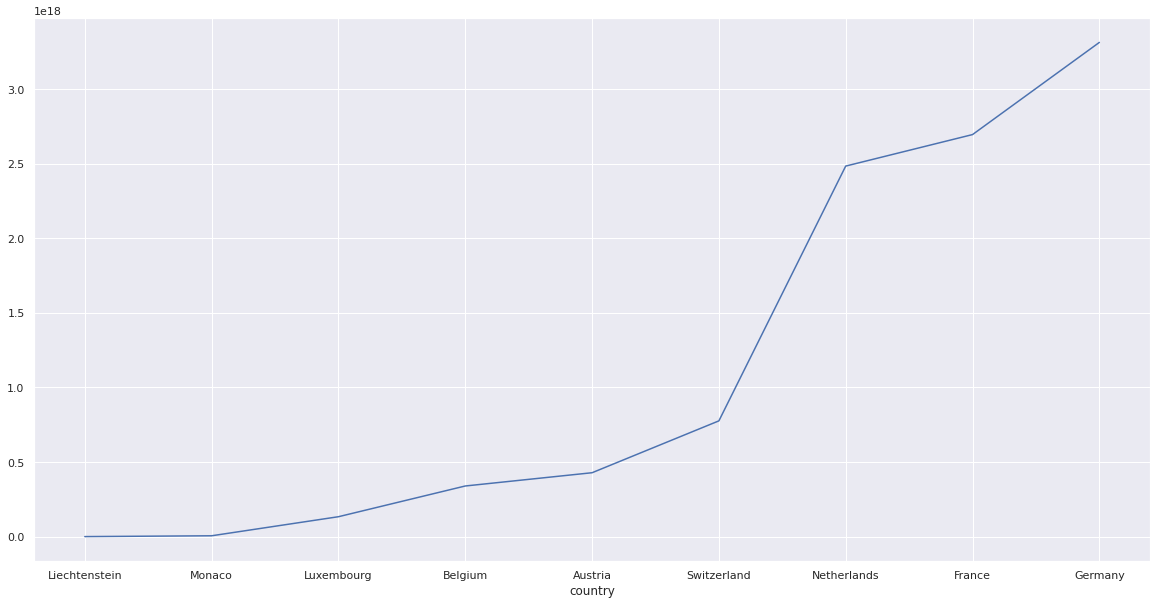

In [858]:
#Plot the duration of all trips in each 'Western Europe' country.
totalspenttime.plot(figsize=(20,10))

**Conclussion:** Nomads don't like Leichtenstein apparantly.

*Or* there is fewer job opportunities in smaller countries, but who knows?


#d. Start up founders trips average

We need to find the average trip duration for all usernames in the trips DataFrame.

Then we remove those people with NaN values, as we cannot use those for start ups or for calculating averages.

Finally, we can group by the boolean value if the person is a start up founder, and by the average trip duration



In [705]:
#Group by the username, then calculate the average trip_duration.
username_avg_trip_duration = trips.groupby(by='username').trip_duration.mean(numeric_only=False)

In [706]:
#Lets get that calculation onto the people dataframe. 
people = pd.merge(people,username_avg_trip_duration,how='left',on='username')

In [707]:
#We want to drop those without nonavailable values from the dataframe
people_filtered = people.dropna(axis=0, how='any')

In [628]:
#Now we need to calculate the mean for the Startup Founders. 
stuf_mean = people_filtered.groupby(by='stuf').trip_duration.mean(numeric_only=False)
stuf_mean

stuf
False   31 days 14:58:30.702654
True    31 days 21:42:14.393697
Name: trip_duration, dtype: timedelta64[ns]

We can conclude that if you are a startup founder, your trips on average is 31 days and 22 hours, while the average trip for everyone else is 31 days and 15 hours.

Technically, yes their trips are longer, but not significally. 

#e. Over time median trip duration overall. 

We can use the .resample() function to convert the date_start column that is set as the index from dates to weeks.

Then we use the .size() function to calculate the size per week

The we use the .plot() to plot the size of each week. This plot doesn't give us any useful information though. 

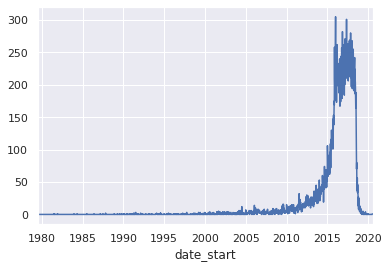

In [715]:
trips.resample('W').size().plot()

Unfortunately the plotting doesn't give us any useful information, beside that there was a huge increase in the amount of nomad trips around 2012. Or more people started registering their trips. Nobody knows from this dataset. 